# Zillow: What is driving the errors in the Zestimates?
  
Project and final report created by Brad Gauvin 05 Aug 2022

## Project Description
Zillow has produced their data and projected prices.  The sales price will differ from the predicted price, but zillow has calculated the error rate between estimated price and sales price.  The project is looking to improve this error rate through clustering methodologies.

#### Audience:
- Audience is a team of Zillow Data scientists

## Project Goal
The goal of this project is to find drivers of logerror and improve zillow model to predict logerror.



# Setup

## Library import
We import all the required Python libraries

In [1]:
from env import get_db_url
import wrangle_zillow
import model
import utilities

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from matplotlib import rcParams

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from decimal import *

alpha = 0.05
rcParams['figure.figsize'] = 16,8
sns.set(font_scale=1.5)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



# 1. Acquire Data 
Data was pulled from the Codeup SQL database using the following query

In [2]:
query = """
        SELECT prop.*, 
               pred.logerror, 
               pred.transactiondate, 
               air.airconditioningdesc, 
               arch.architecturalstyledesc, 
               build.buildingclassdesc, 
               heat.heatingorsystemdesc, 
               landuse.propertylandusedesc, 
               story.storydesc, 
               construct.typeconstructiondesc 
        FROM   properties_2017 prop  
               INNER JOIN (SELECT parcelid,
                                  logerror,
                                  Max(transactiondate) transactiondate 
                           FROM   predictions_2017 
                           GROUP  BY parcelid, logerror) pred
                       USING (parcelid) 
               LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
               LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
               LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
               LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
               LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
               LEFT JOIN storytype story USING (storytypeid) 
               LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
        WHERE  prop.latitude IS NOT NULL 
               AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
        """

In [3]:
# Acquire data from SQL using module found in wrangle_zillow.py
df = wrangle_zillow.get_zillow()
# Summarize info
utilities.summary_info(df)
# Obtain number of rows and columns for orginal dataframe
df.shape

Reading from csv file...
--- Shape: (77381, 67)
--- Descriptions
                   parcelid  airconditioningtypeid  architecturalstyletypeid  \
count             77,381.00              24,953.00                    206.00   
unique                  NaN                    NaN                       NaN   
top                     NaN                    NaN                       NaN   
freq                    NaN                    NaN                       NaN   
mean          13,007,150.51                   1.81                      7.39   
std            3,481,345.65                   2.97                      2.73   
min           10,711,855.00                   1.00                      2.00   
25%           11,538,305.00                   1.00                      7.00   
50%           12,531,568.00                   1.00                      7.00   
75%           14,211,831.00                   1.00                      7.00   
max          167,689,317.00                  13.00     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   architecturalstyletypeid      206 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77381 non-null  float64
 5   bedroomcnt                    77381 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49672 non-null  float64
 8   calculatedbathnbr             76772 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6023 non-null   float64
 11  calculatedfinishedsquarefeet  77185 non-null  float64
 12  finishedsquarefeet12          73749 non-null  float64
 13  f

(77381, 67)

# Data processing
- Multi-step process was used
    1. Filter for single family residences
    2. Missing Data was identified by row and column, filling key elements and eliminating others
    3. Drop unnecessary/Duplicate columns
    4. Update data (latitude/longitude) to represent actual numbers needed
    5. OUtliers are visually identified and eliminated using IQR methods

In [4]:
# To limit to single_family_homes
df = wrangle_zillow.single_family_homes(df)
# Address Missing values by column
utilities.missing_values_per_column(df)
#Remove Unused Columns
df = utilities.remove_columns(df, cols_to_remove = ['censustractandblock','finishedsquarefeet12','buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc', 'unitcnt'])
# Fix Latitude & longitude
df.latitude = df.latitude / 1_000_000
df.longitude = df.longitude / 1_000_000
#Missing values check
utilities.missing_values_per_column(df)
#Missing row data
utilities.missing_values_per_row(df)
#Function to handle missing data
df = utilities.handle_missing_values(df, prop_required_column = .5, prop_required_row = .5)
# Adds bins, column name changes, and other cleaning 
df = utilities.data_prep(df, prop_required_column=.5, prop_required_row=.5)
df.head().T

(62210, 37)


,0,1,2,3,4
parcelid,14297519,17052889,14186244,12177905,10887214
bathroomcnt,3.50,1.00,2.00,3.00,3.00
bedroomcnt,4.00,2.00,3.00,4.00,3.00
calculatedbathnbr,3.50,1.00,2.00,3.00,3.00
calculatedfinishedsquarefeet,"3,100.00","1,465.00","1,243.00","2,376.00","1,312.00"
fips,"6,059.00","6,111.00","6,059.00","6,037.00","6,037.00"
fullbathcnt,3.00,1.00,2.00,3.00,3.00
latitude,33.63,34.45,33.89,34.25,34.19
longitude,-117.87,-119.28,-117.82,-118.24,-118.41
lotsizesquarefeet,"4,506.00","12,647.00","8,432.00","13,038.00","278,581.00"


### Handling outliers

- Need to see if outliers are present and at which rate.  Therefore a visual representation is necessary to identify outliers.  Using a boxplot will highlight which variables are outside of the 75 percentile and we can use an IQR methodology to eliminate any unecessary outliers.  However, the goal is to keep data above the 52K rows mentioned in the rubric.

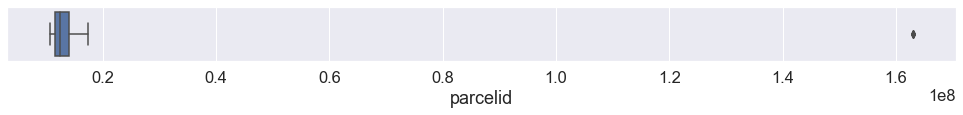

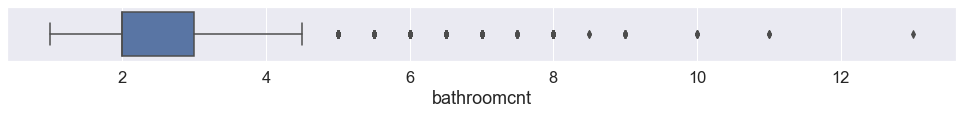

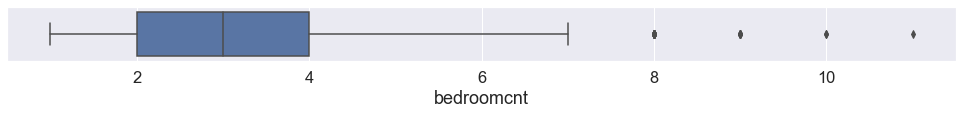

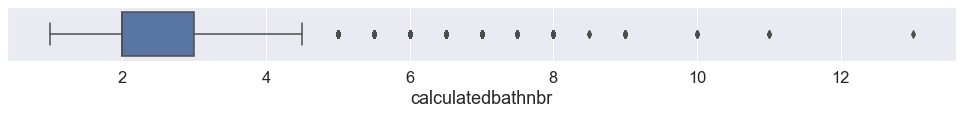

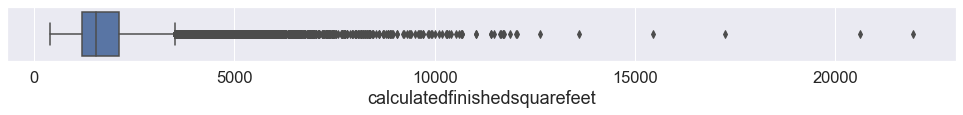

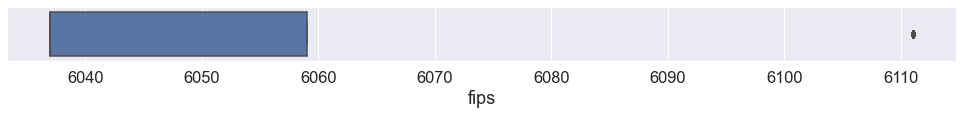

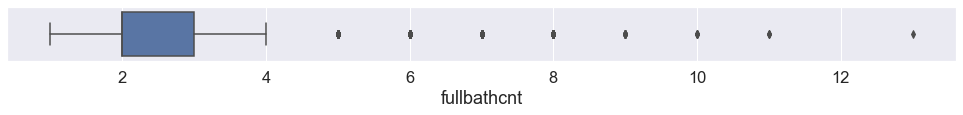

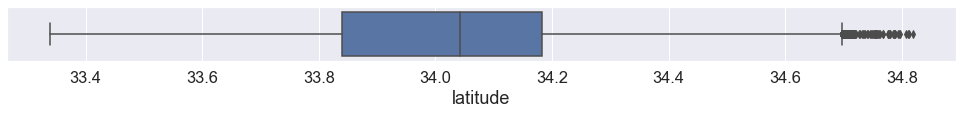

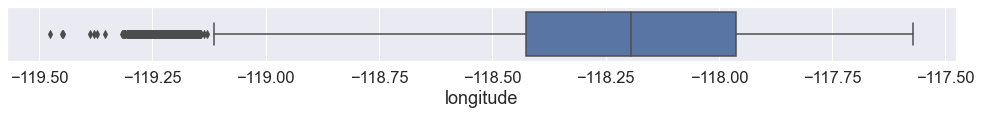

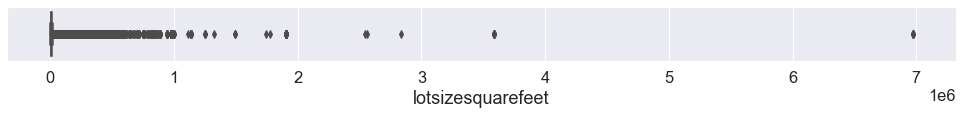

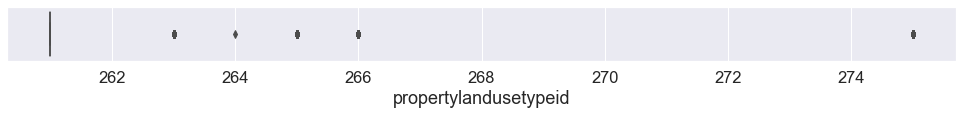

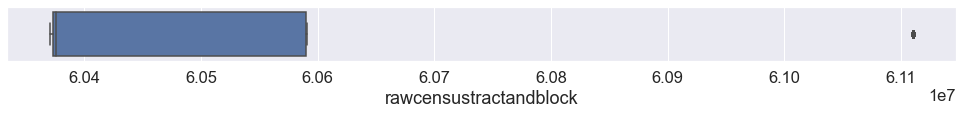

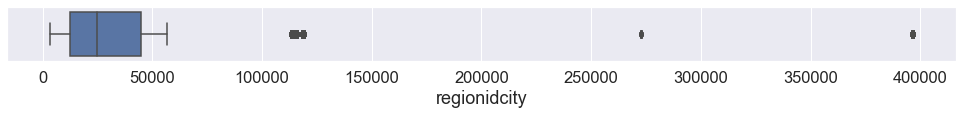

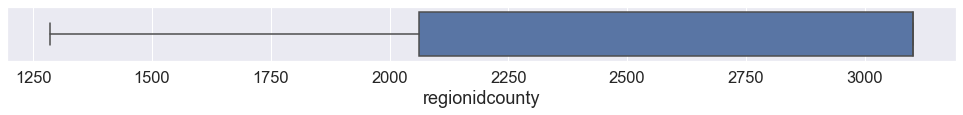

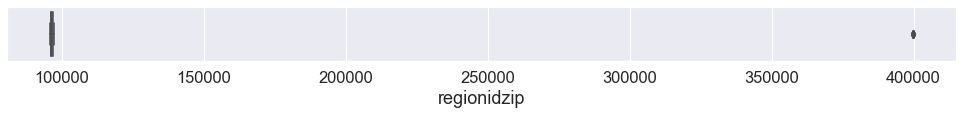

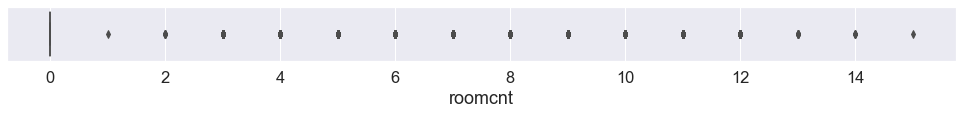

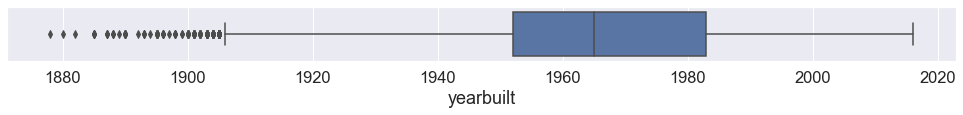

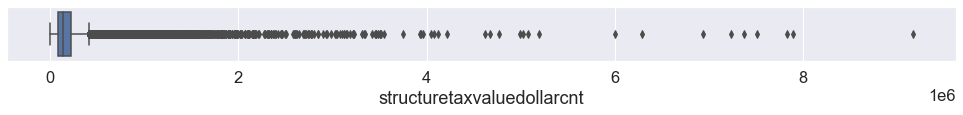

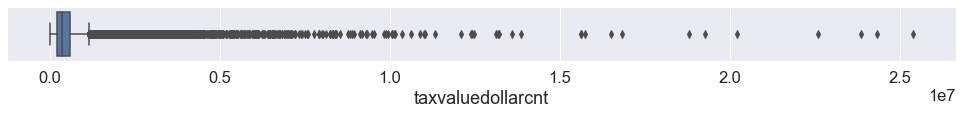

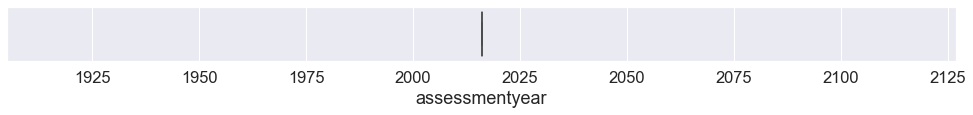

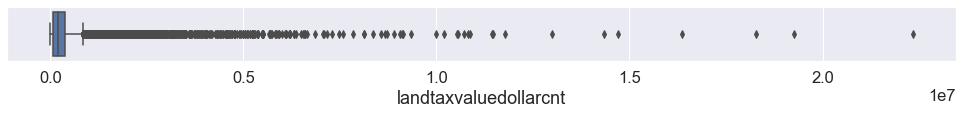

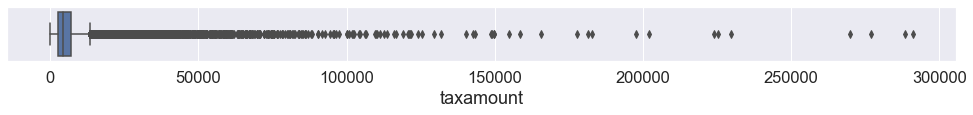

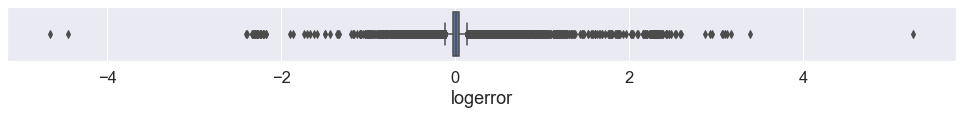

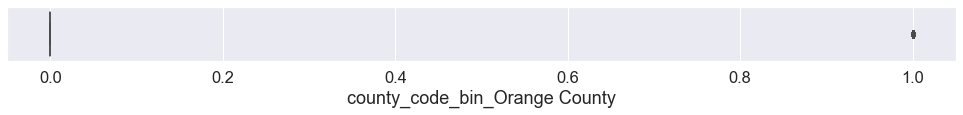

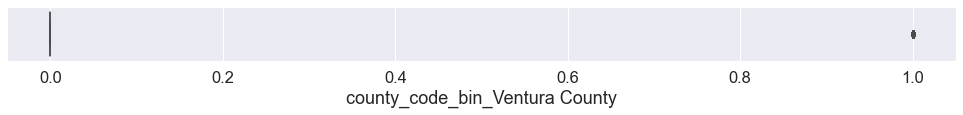

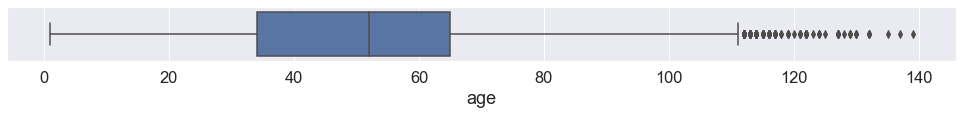

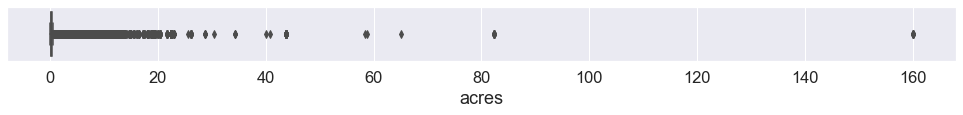

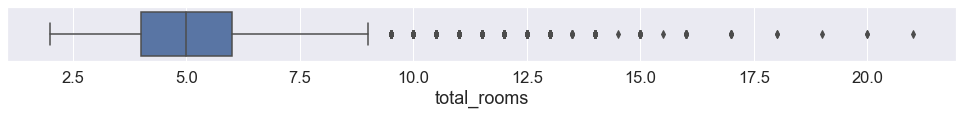

In [5]:
# Boxplot for outliers
df1=df.select_dtypes('number')
for column in df1:
    plt.figure(figsize=(17,1))
    sns.boxplot(df[column])

In [6]:
# Remove outliers in bath, bedroom, squarefeet, lotsize, and tax value using IQR approch. K=3.0 to limit data removal to <20% 
# Keeping it around the rubric lines of data 52,442 
df= utilities.remove_outliers(df, 3.0, ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','taxvaluedollarcnt'])
df.shape

Number of observations removed: 9979


(52231, 37)

### Explore Phase
- Univariate Exploration
- bivariate exploration

#### Key questions/hypotheses
- How do variables correlate?
- How does `logerror` relate with geography?
- How do `logerror` and acres vary by county?
- What categories have statistically significant absolute log errors greater than overall mean?


#### Start with splitting data

In [7]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


Text(0.5, 0, 'Log Error')

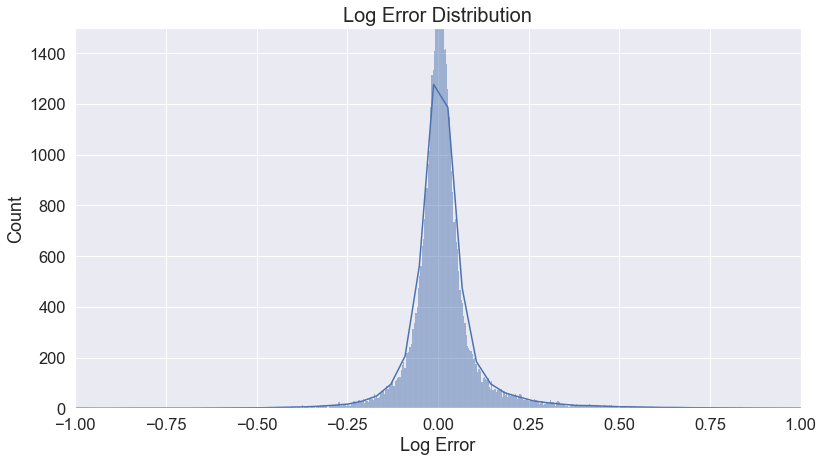

In [8]:
# Set size of figure
plt.figure(figsize = (13,7))
# Create histogram
ax = sns.histplot(data=df, x="logerror", kde=True)
# set x and y limits to 'zoom in'
ax.set(xlim = (-1, 1), ylim = (0, 1500)) # set the limits to the desired ones

plt.title('Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

In [9]:
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

#### Question 1:

- How do the variables correlate to target logerror?

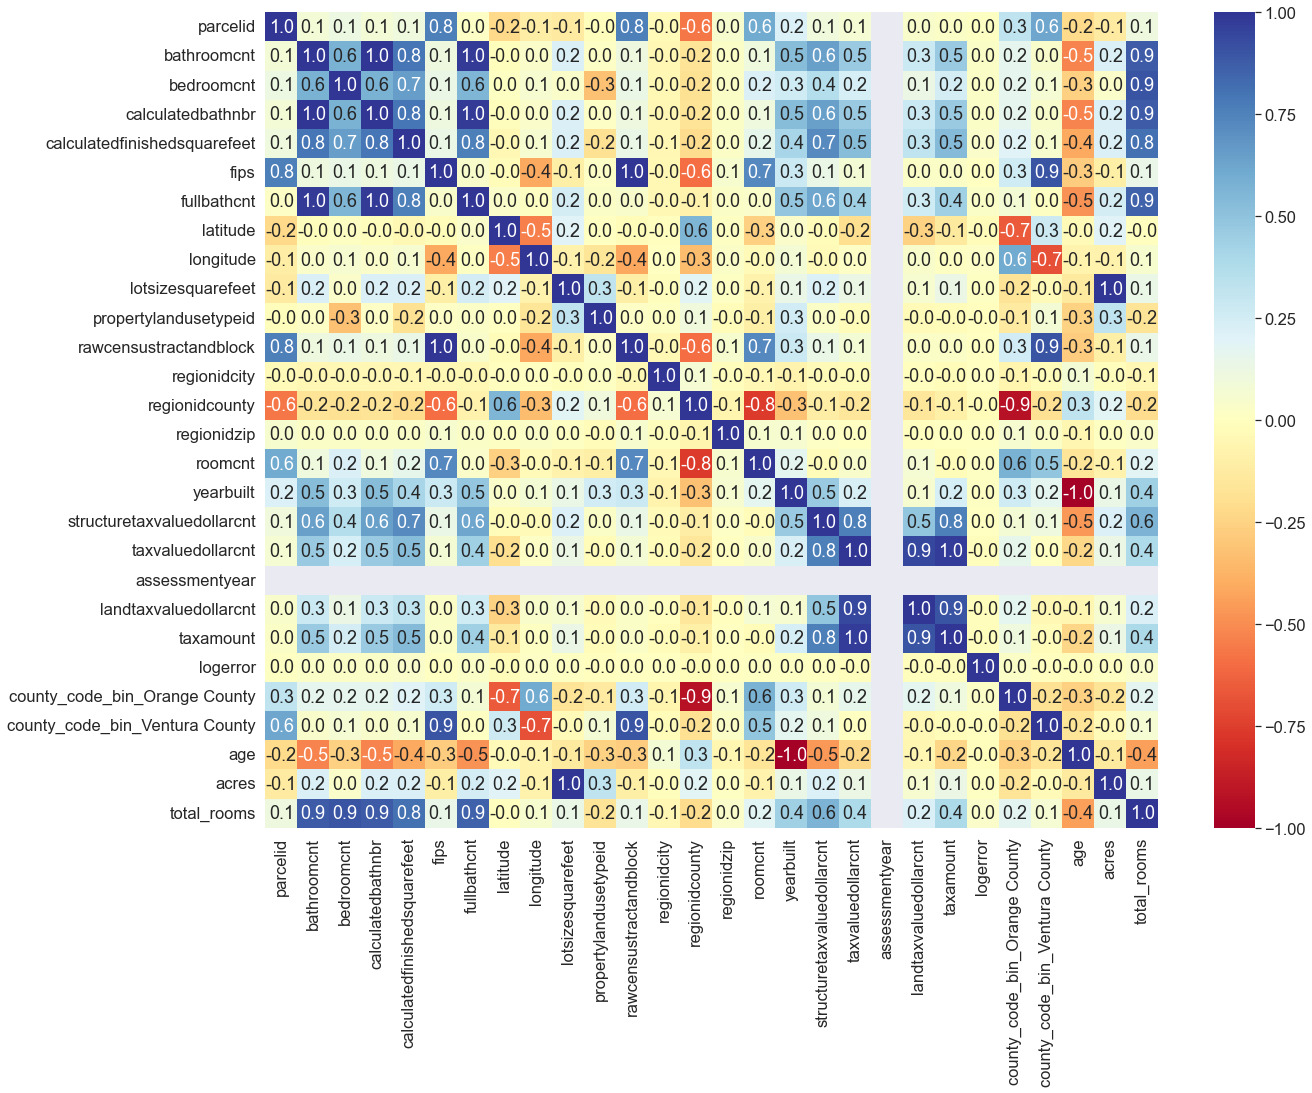

In [12]:
# Heatmap to display correlation of the features and logerror.
plt.figure(figsize = (20, 15))
sns.heatmap(df.corr(), cmap="RdYlBu", annot=True, fmt=".1f")
plt.show()

#### Takeaway:
 - Need to find other ways to correlate variables

#### Question 2:

 - How does logerror relate with geography?

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

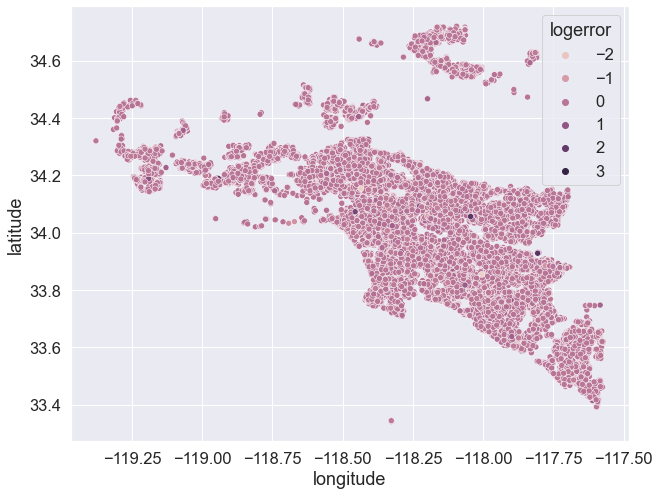

In [13]:
# Logerror visual on map
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x='longitude',y='latitude',hue='logerror')

#### Question 3

- How do 'logerror' and acres vary by county?

<Figure size 936x504 with 0 Axes>

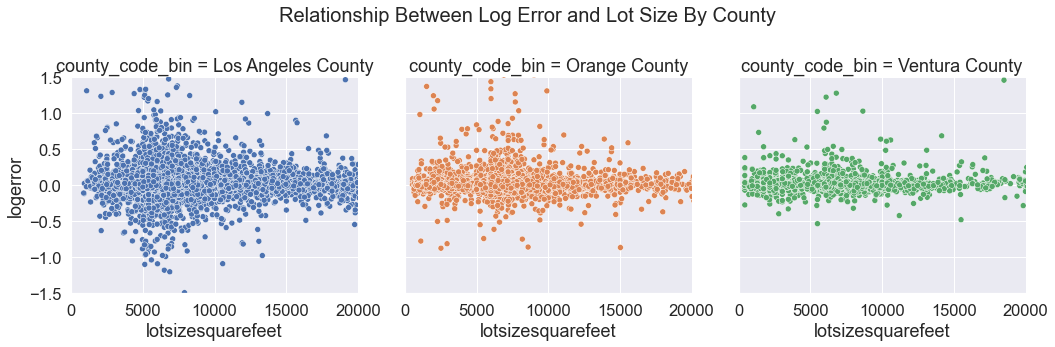

In [18]:
# Visual for logerror by county
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.relplot(data=train, x= x, y= y, hue="county_code_bin", col="county_code_bin", legend=False)
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.suptitle('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

Text(0.5, 1.0, 'County v. Log Error')

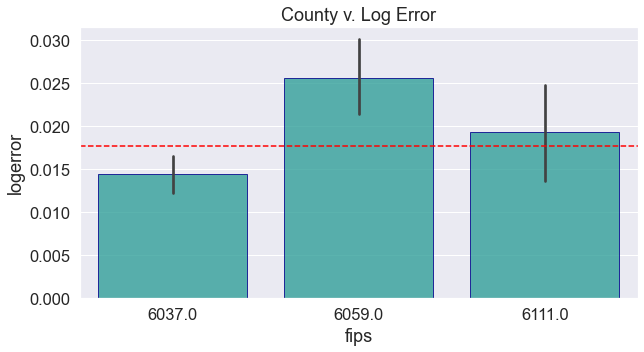

In [19]:
# Bar Graph to see log error mean vs county
p = plt.figure(figsize=(10,5))
p = sns.barplot(train.fips, train.logerror, data=train, alpha=.8, color='lightseagreen', edgecolor = 'darkblue')
overall_rate = train.logerror.mean()
p = plt.axhline(overall_rate, ls='--', color='red', )
plt.title('County v. Log Error')

In [20]:
# H0 - There is no linear relationship between lot size and logerror.
# H1 - There is a linear realtionship between lot size and log error.
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.013285493817789484
p = 0.023080802668538656
We reject the H0.


- Question 3a: What about by county?
 - Is it significant?

In [23]:
# Hypothesis Testing
train.groupby('county_code_bin').apply(lambda subset: stats.pearsonr(subset.lotsizesquarefeet, subset.logerror))
α = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 6111], train.logerror[train.fips == 6037], train.logerror[train.fips == 6059])
F, p
null_hypothesis = 'no significant difference in logerror for properties in LA County vs Orange County vs Ventura County'

if p > α:
    print("We fail to reject the null hypothesis. The null hypothesis is of", null_hypothesis)
else:
    print("We reject the null hypothesis of", null_hypothesis)

We reject the null hypothesis of no significant difference in logerror for properties in LA County vs Orange County vs Ventura County


#### Question 4: What is overall mean logerror?

- Used as a baseline logerror overall
- Needed to find which features are above this overall mean

In [24]:
# Building variables to test on
overall_mean = train.logerror.mean()
high_cols =[]
high_option = []
high_difference = []
option_means = []
option_sample_size=[]

print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].logerror, train.logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].logerror.mean()
                    difference = sample_mean - overall_mean
                    sample_size = len(train[train[col]==option].logerror)
                    # print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")
                    
                    # Only saving those values with greater than average absolute log errors and decent sampel
                    if (difference>0) and (sample_size>100):
                        high_cols.append(col)
                        high_option.append(option)
                        high_difference.append(difference)
                        option_means.append(sample_mean)
                        option_sample_size.append(len(train[train[col]==option].logerror))

high_log_errors = pd.DataFrame(data = {'column':high_cols,
                                      'option': high_option,
                                      'mean_log_error': option_means,
                                      'difference_from_overall': high_difference,
                                      'option_sample_size':option_sample_size})

Overall mean logerror: 0.017734656591149353


In [27]:
high_log_errors.sort_values(by='difference_from_overall', ascending=False).head(6)

,column,option,mean_log_error,difference_from_overall,option_sample_size
14,logerror_bins,"(0.2, 4.0]",0.48,0.46,1263
13,logerror_bins,"(0.05, 0.2]",0.09,0.08,4671
9,home_sizes,Large: 4000 - 5999sqft,0.07,0.05,342
12,bathroom_bins,Large: 5-6 bathrooms,0.04,0.03,525
4,fullbathcnt,4.00,0.04,0.02,1204
10,bedroom_bins,Large: 5-6 bedrooms,0.03,0.01,1859


### Takeaway:

Takeaways based on t-test with high positive error differences:
Larger home sizes
Larger bathrooms
Larger Bedrooms

Larger homes have seem to be key factor

#### County is factor in Logerror

### Scaling Data
 - Using scaled data for questions

In [28]:
# SPlitting by key variables identified in EDA
train_scaled, validate_scaled, test_scaled = model.scale_data(train, validate, test, ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'latitude',
       'longitude', 'lotsizesquarefeet', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror','county_code_bin_Orange County', 'county_code_bin_Ventura County',
       'age','acres', 'total_rooms'])

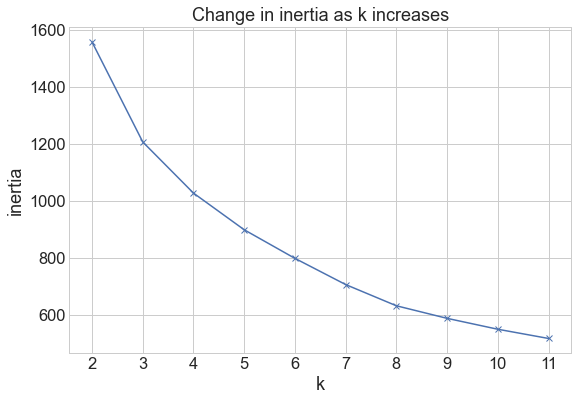

In [29]:
# Identifying Key sets of variables to cluster against
home_scale = (['bathroomcnt_scaled','bedroomcnt_scaled','calculatedfinishedsquarefeet_scaled','lotsizesquarefeet_scaled','age_scaled'])
price_scale = (['taxvaluedollarcnt_scaled','landtaxvaluedollarcnt_scaled','taxamount_scaled','age_scaled'])
key_variables_scale = (['age_scaled','calculatedfinishedsquarefeet_scaled','taxvaluedollarcnt_scaled'])
# Setting first key variables
X = train_scaled[key_variables_scale]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

Text(0.5, 0, 'Cluster')

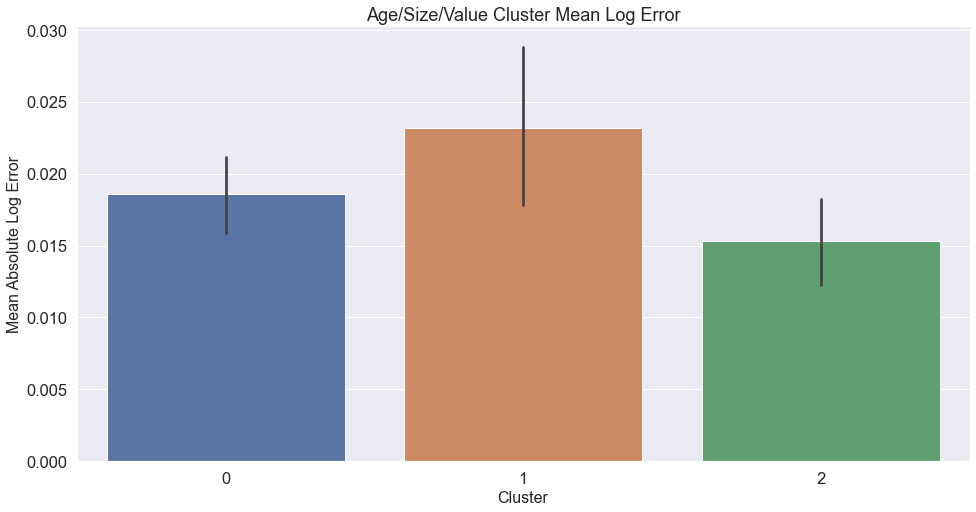

In [30]:
# Using K3 and fitting for Kmeans
kmeans = KMeans(n_clusters=3, random_state=123)
kmeans.fit(X)

train_scaled['age_size_value_cluster'] = kmeans.predict(X)
train_scaled.age_size_value_cluster = train_scaled.age_size_value_cluster.astype('category')

#plotting with output
plt.figure(figsize=(16,8))
sns.barplot(data = train_scaled, x = 'age_size_value_cluster', y='logerror')
plt.title("Age/Size/Value Cluster Mean Log Error")
plt.ylabel("Mean Absolute Log Error", fontsize=16)
plt.xlabel("Cluster", fontsize=16)

In [31]:
# Looking for significance
overall_mean = train_scaled.logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in set(train_scaled.age_size_value_cluster):
    sample = train_scaled[train_scaled.age_size_value_cluster==col]
    t, p = stats.ttest_1samp(sample.logerror, overall_mean)
    print(col, "Significant? ", p<alpha, "t value: ", t)

Overall mean logerror: 0.017734656591149353
0 Significant?  False t value:  0.6316462191820209
1 Significant?  False t value:  1.9165972040488544
2 Significant?  False t value:  -1.6041616686988496


#### Cluster by price Scale (Value)

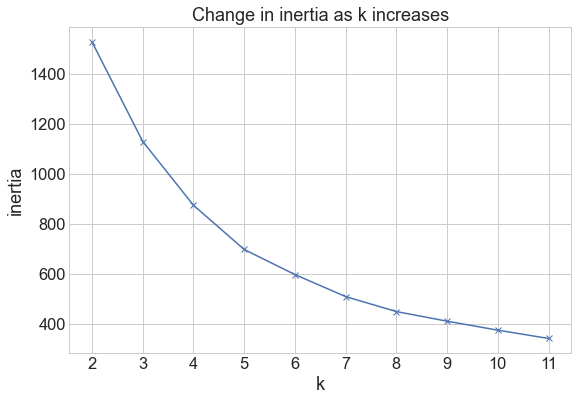

In [32]:
# Setting preset variables in for price
X = train_scaled[price_scale]
# Plotting
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

K=5

Text(0.5, 0, 'Cluster')

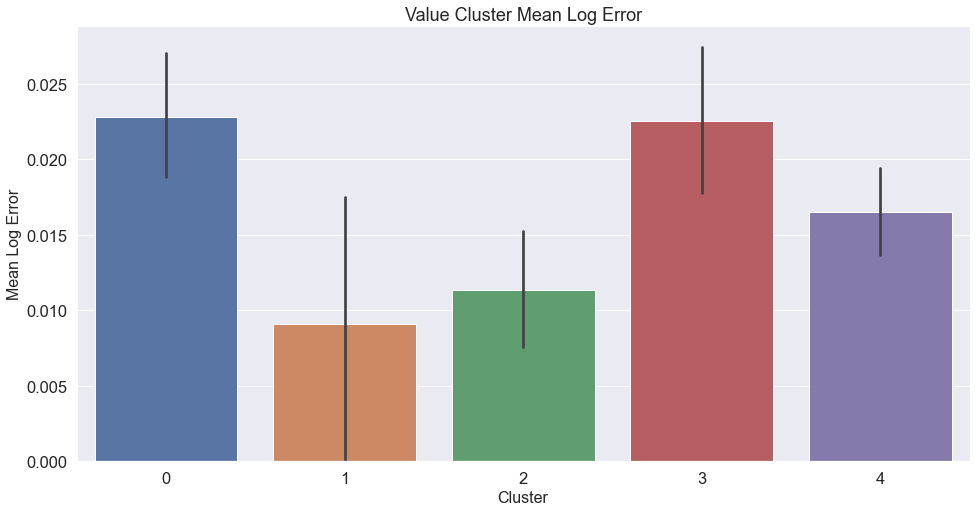

In [33]:
# Fitting
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X)

train_scaled['value_cluster'] = kmeans.predict(X)
train_scaled.age_size_value_cluster = train_scaled.age_size_value_cluster.astype('category')
#Plotting
plt.figure(figsize=(16,8))
sns.barplot(data = train_scaled, x = 'value_cluster', y='logerror')
plt.title("Value Cluster Mean Log Error")
plt.ylabel("Mean Log Error", fontsize=16)
plt.xlabel("Cluster", fontsize=16)

In [34]:
# Statistical Significance?
overall_mean = train_scaled.logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in set(train_scaled.value_cluster):
    sample = train_scaled[train_scaled.value_cluster==col]
    t, p = stats.ttest_1samp(sample.logerror, overall_mean)
    print(col, "Significant? ", p<alpha, "t value: ", t)

Overall mean logerror: 0.017734656591149353
0 Significant?  True t value:  2.582790682324217
1 Significant?  False t value:  -1.9502324466778003
2 Significant?  True t value:  -3.3419250315527633
3 Significant?  False t value:  1.9242530059489003
4 Significant?  False t value:  -0.8132300166257408


Text(0.5, 1.0, 'Cluster 0 is old and low, Cluster 1 is High, Cluster 3 is old and mid, Cluster 4 is Young and mid, Cluster 5 is Young and low')

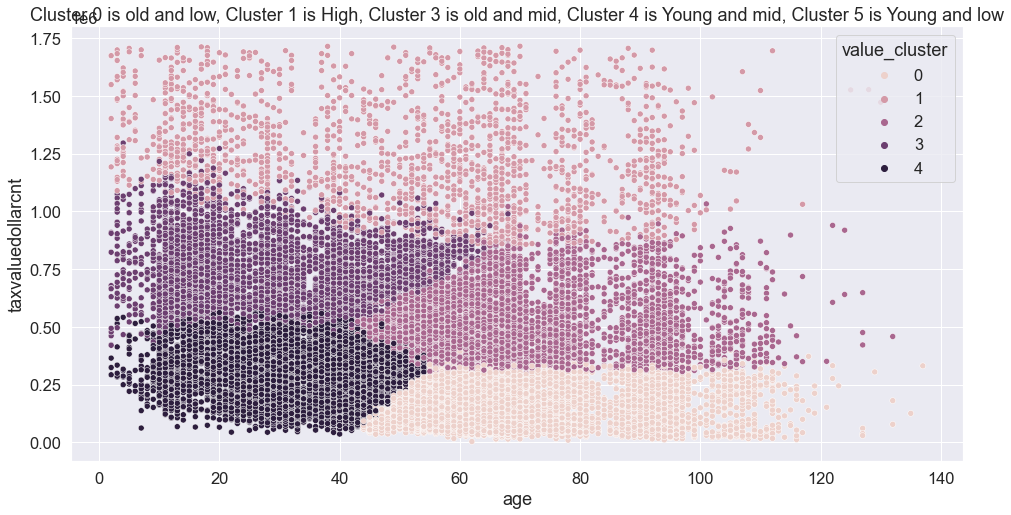

In [36]:
# Visual for cluster
# Unscaled data based on clusters
sns.scatterplot(data = train_scaled, x = 'age', y='taxvaluedollarcnt', hue='value_cluster')
plt.title("Cluster 0 is old and low, Cluster 1 is High, Cluster 3 is old and mid, Cluster 4 is Young and mid, Cluster 5 is Young and low")


#### On Home feature set

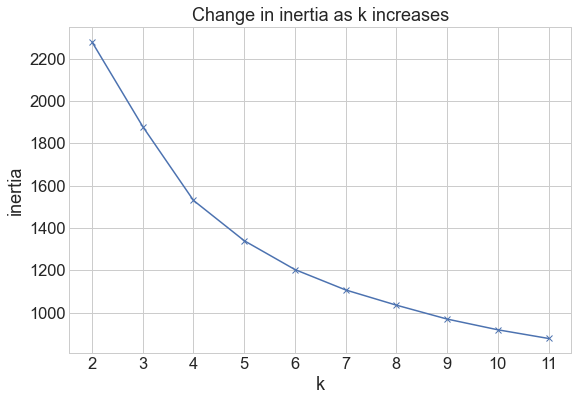

In [37]:
# Home feature selection
X = train_scaled[home_scale]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k, random_state=123).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### K=4

Text(0.5, 0, 'Cluster')

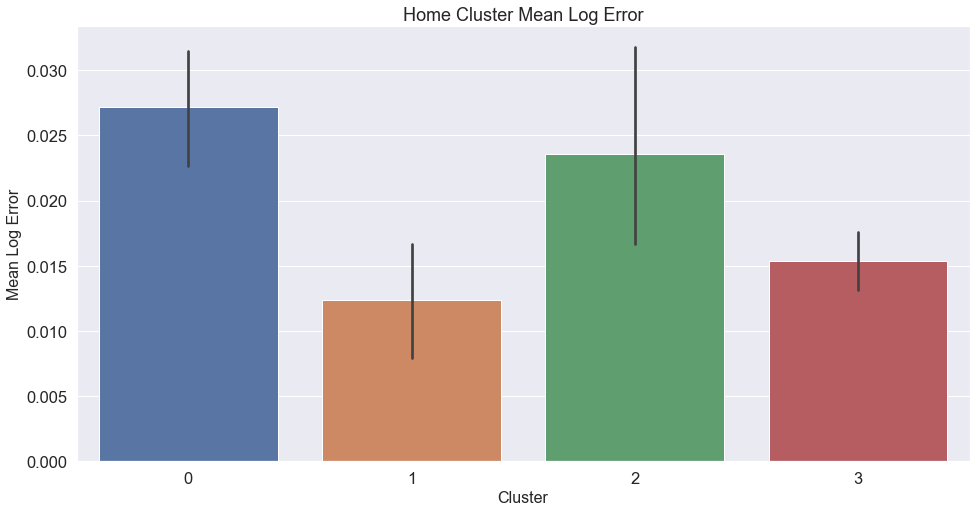

In [39]:
# Fitting
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(X)

train_scaled['home_cluster'] = kmeans.predict(X)
train_scaled.home_cluster = train_scaled.home_cluster.astype('category')

# Plotting
plt.figure(figsize=(16,8))
sns.barplot(data = train_scaled, x = 'home_cluster', y='logerror')
plt.title("Home Cluster Mean Log Error")
plt.ylabel("Mean Log Error", fontsize=16)
plt.xlabel("Cluster", fontsize=16)

- statistical Significance?

In [41]:
# Statistical Significance
overall_mean = train_scaled.logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in set(train_scaled.home_cluster):
    sample = train_scaled[train_scaled.home_cluster==col]
    t, p = stats.ttest_1samp(sample.logerror, overall_mean)
    print(col, "Significant? ", p<alpha, "t value: ", t)

Overall mean logerror: 0.017734656591149353
0 Significant?  True t value:  4.204509189765621
1 Significant?  True t value:  -2.302433951553634
2 Significant?  False t value:  1.5289661817110194
3 Significant?  True t value:  -1.981747533584819


Text(0.5, 1.0, 'Chaos version 1')

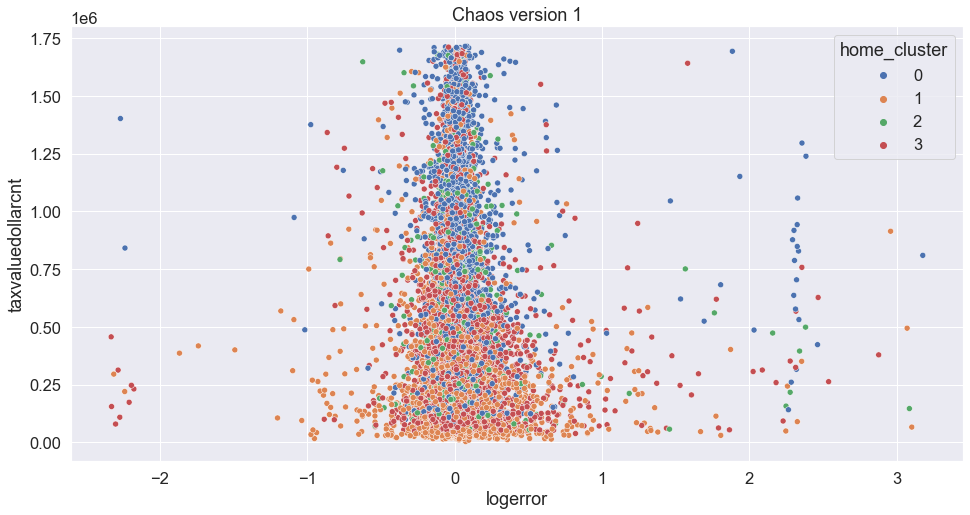

In [42]:
# Visual
# Unscaled data based on clusters
sns.scatterplot(data = train_scaled, x = 'logerror', y='taxvaluedollarcnt', hue='home_cluster')
plt.title("Chaos version 1")

### Key variables Takeaway
 - Clustering on variable sets didn't produce much data.
 - Variables based on home had best statistical significance but visuals didn't produce meaningful information

- Chose to do a fifth simplified set based on age and square feet
    - This also did not produce any statistically significant data.

## Exploration Summary
### Clustering takeaway - 
- Home cluster is working the best.  Going to move forward to MVP with Home Cluster.
- May test more if more time is available.

### Regarding Logerror
- Home data was the only group that had statistical significance to logerror.
- While not strong data to support this, it's good enough to create dummy clusters and models to base it off of.

### Work Toward MVP
 - Possible future work, but need MVP prior to continuing.  

